https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2022.954024/full
^^ the ones closest to the centroid best represent the group

**group embeddings by trend and get the nearest to centroid of each to represent the trend**

In [ ]:
import os
import numpy as np
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def cosine_similarity_vec(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def load_embeddings_for_videos(video_names, modalities, emb_folder="similarity pipeline/embeddings_out"):
 
    folder_map = {
        "audio": "audio2048",
        "visual": "video2048", 
        "text": "text768"
    }

    video_embs = {vid:{} for vid in video_names}
    
    for vid in video_names:
        for mod in modalities:
            dim = "768" if mod == "text" else "2048"
            folder = os.path.join(emb_folder, folder_map[mod])
            fname = f"{vid}_emb-{mod}{dim}.npy"
            path = os.path.join(folder, fname)
            
            if os.path.exists(path):
                video_embs[vid][mod] = np.load(path)
            else:
                print(f"⚠️ Missing {mod} embedding for {vid}")
    
    return video_embs

def compute_weighted_scores(video_embs, weights):
    scores = {}
    videos = list(video_embs.keys())
    
    for candidate in videos:
        total_score = 0.0
        count = 0
        for other in videos:
            if candidate == other:
                continue
            sim_sum = 0.0
            total_weight = 0.0
            for mod, w in weights.items():
                if mod in video_embs[candidate] and mod in video_embs[other]:
                    sim = cosine_similarity_vec(video_embs[candidate][mod], video_embs[other][mod])
                    sim_sum += sim * w
                    total_weight += w
            if total_weight > 0:
                total_score += sim_sum
                count += 1
        scores[candidate] = total_score / max(1, count)
    
    return scores

def pick_representative(video_names, video_embs, weights):
    scores = compute_weighted_scores(video_embs, weights)
    best_vid = max(scores.items(), key=lambda x: x[1])[0]
    return best_vid, scores

video_names = [
    "trend9vid1",
    "trend9vid2",
    "trend9vid3",
    "trend9vid4",
    "trend9vid5",
    "trend9vid6",
    "trend9vid7",
    "trend9vid8",
    "trend9vid9",
    "trend9vid10"
]

modalities = ["audio", "visual", "text"]  # visual instead of video
weights = {"audio": 1/3, "visual": 1/3, "text": 1/3}



video_embs = load_embeddings_for_videos(video_names, modalities)
rep_video, scores = pick_representative(video_names, video_embs, weights)

print(f"Representative video: {rep_video}\n")
print("Scores:")
for vid, score in scores.items():
    print(f"{vid}: {score:.4f}")

Representative video: trend9vid7

Scores:
trend9vid1: 0.7103
trend9vid2: 0.6663
trend9vid3: 0.6913
trend9vid4: 0.6723
trend9vid5: 0.7110
trend9vid6: 0.7040
trend9vid7: 0.7466
trend9vid8: 0.7047
trend9vid9: 0.6938
trend9vid10: 0.7379


In [7]:
def visualize_trend(video_embs, weights, rep_video):

    modalities = list(weights.keys())

    for mod in modalities: # per modality! reduce embeddings and plot them
        mod_embs = []
        labels = []
        for vid, emb_dict in video_embs.items():
            if mod in emb_dict:
                mod_embs.append(emb_dict[mod])
                labels.append(vid)

        if len(mod_embs) == 0:
            print(f"[{mod.upper()}] No embeddings found, skipping...")
            continue

        mod_embs = np.array(mod_embs)
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(mod_embs)

        centroid = np.mean(reduced, axis=0)

        plt.figure(figsize=(6, 5))
        plt.scatter(reduced[:, 0], reduced[:, 1], label="Videos", color="skyblue")
        plt.scatter(*centroid, color="red", marker="*", s=200, label="Centroid")

        #representataive video
        if rep_video in labels:
            idx = labels.index(rep_video)
            plt.scatter(reduced[idx, 0], reduced[idx, 1], color="orange", s=150, label="Representative")
            plt.text(reduced[idx, 0]+0.02, reduced[idx, 1]+0.02, rep_video, fontsize=9)

        plt.title(f"{mod.upper()} modality embeddings")
        plt.legend()
        plt.show()

        dists = np.linalg.norm(reduced - centroid, axis=1)
        avg_dist = np.mean(dists)
        rep_dist = dists[labels.index(rep_video)] if rep_video in labels else None

        print(f"\n[{mod.upper()}]")
        print(f"Average distance to centroid: {avg_dist:.4f}")
        if rep_dist is not None:
            print(f"Representative video '{rep_video}' distance: {rep_dist:.4f}")
        print("-" * 40)

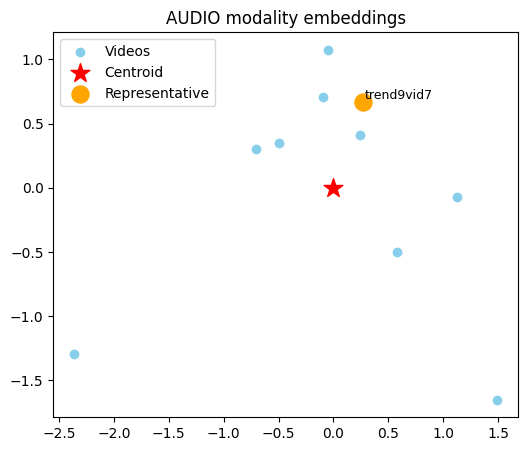


[AUDIO]
Average distance to centroid: 1.1172
Representative video 'trend9vid7' distance: 0.7200
----------------------------------------


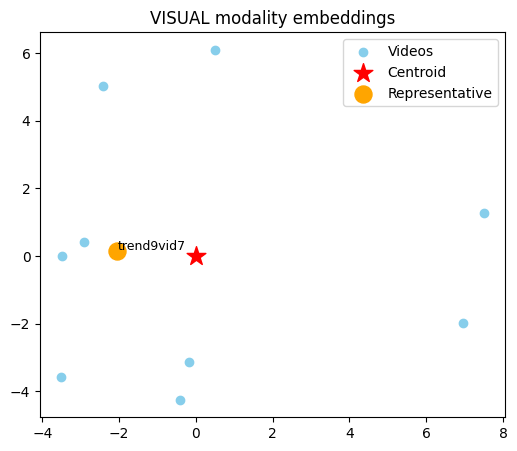


[VISUAL]
Average distance to centroid: 4.7480
Representative video 'trend9vid7' distance: 2.0535
----------------------------------------


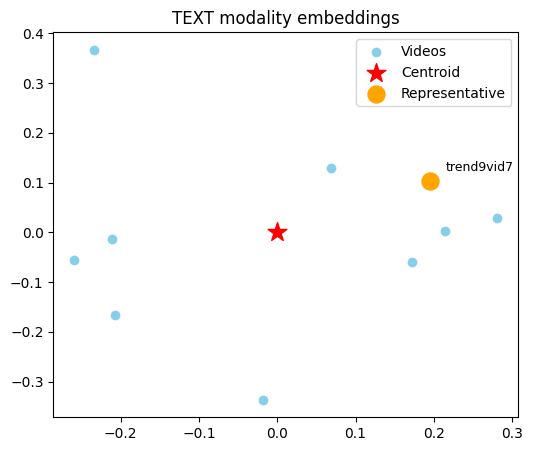


[TEXT]
Average distance to centroid: 0.2561
Representative video 'trend9vid7' distance: 0.2206
----------------------------------------


In [8]:
visualize_trend(video_embs, weights, rep_video)